In [1]:
# import torch
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# from generate_data import MyDataset
# from datasets import Dataset
# from datasets import IterableDataset
# import torch
# import os,sys
# from model import RegressionModel
# from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler
# from torch.optim import AdamW
# import torch.nn as nn
# from sklearn.model_selection import train_test_split
# import tqdm
# import numpy as np
# from wireless import LOS_Env
# from transformers import pipeline, set_seed
# import transformers
# from transformers import LlamaTokenizer, LlamaForCausalLM
# from transformers import AutoModelForQuestionAnswering, AutoTokenizer, AutoModel, pipeline
import sionna
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(1)  # Set global random seed for reproducibility

In [3]:
scene = load_scene('mitsuba/campus/campus.xml')  # Try also sionna.rt.scene.etoile
# scene = load_scene(sionna.rt.scene.munich)
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

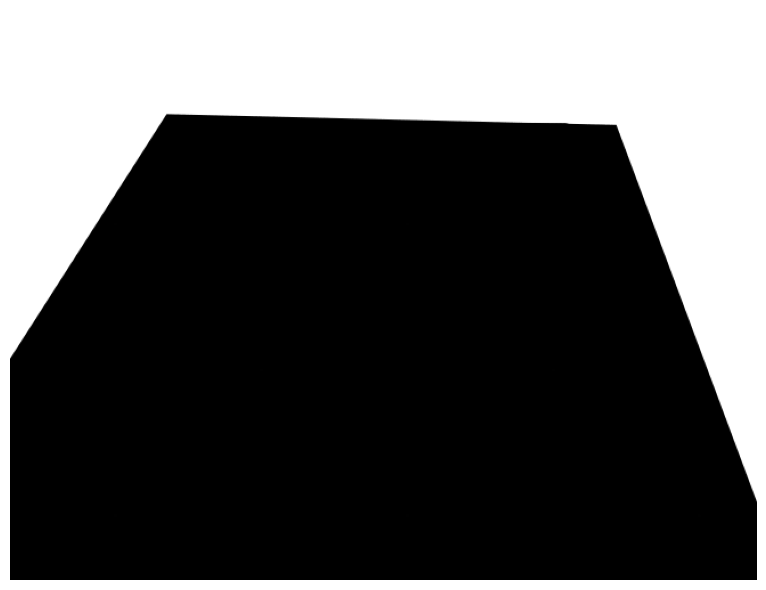

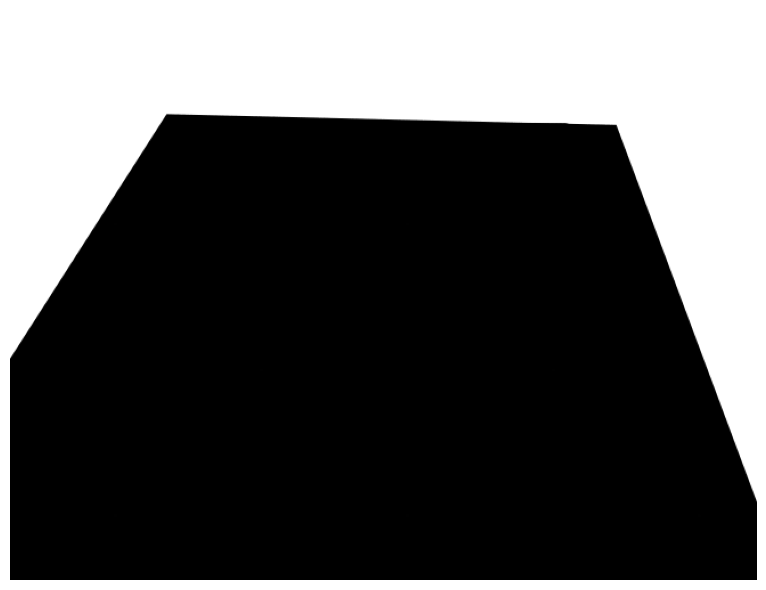

In [4]:
scene.render(camera="preview", num_samples=512)

In [5]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=8,
                          num_cols=2,
                          vertical_spacing=0.7,
                          horizontal_spacing=0.5,
                          pattern="tr38901",
                          polarization="VH")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                          num_cols=1,
                          vertical_spacing=0.5,
                          horizontal_spacing=0.5,
                          pattern="dipole",
                          polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
              position=[8.5,21,27],
              orientation=[0,0,0])
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
           position=[45,90,1.5],
           orientation=[0,0,0])
scene.add(rx)

# TX points towards RX
tx.look_at(rx)

print(scene.transmitters)
print(scene.receivers)

{'tx': <sionna.rt.transmitter.Transmitter object at 0x0000017512CBADF0>}
{'rx': <sionna.rt.receiver.Receiver object at 0x000001754B831850>}


In [6]:
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)

In [7]:
scene.preview(paths=paths) # Open preview showing paths

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

In [8]:
#cm = scene.coverage_map(cm_cell_size=[1.,1.], # Configure size of each cell
#                        num_samples=1e7) # Number of rays to trace

In [9]:

print("Source coordinates: ", paths.sources.numpy())
print("Transmitter coordinates: ", list(scene.transmitters.values())[0].position.numpy())



print("Target coordinates: ",paths.targets.numpy())
print("Receiver coordinates: ",list(scene.receivers.values())[0].position.numpy())


Source coordinates:  [[ 8.5 21.  27. ]]
Transmitter coordinates:  [ 8.5 21.  27. ]
Target coordinates:  [[45.  90.   1.5]]
Receiver coordinates:  [45.  90.   1.5]


In [17]:
path_idx = 4

# For a detailed overview of the dimensions of all properties, have a look at the API documentation
print(f"\n--- Detailed results for path {path_idx} ---")
print(f"Channel coefficient: {paths.mat_t.numpy()}")
print(f"Propagation delay: {paths.tau[0,0,0,path_idx].numpy()*1e6:.5f} us")
print(f"Zenith angle of departure: {paths.theta_t[0,0,0,path_idx]:.4f} rad")
print(f"Azimuth angle of departure: {paths.phi_t[0,0,0,path_idx]:.4f} rad")
print(f"Zenith angle of arrival: {paths.theta_r[0,0,0,path_idx]:.4f} rad")
print(f"Azimuth angle of arrival: {paths.phi_r[0,0,0,path_idx]:.4f} rad")


--- Detailed results for path 4 ---
Channel coefficient: [[[[[[ 1.2177478e-02+0.0000000e+00j  1.8145856e-10+0.0000000e+00j]
     [ 3.6291711e-10+0.0000000e+00j -1.2177478e-02+0.0000000e+00j]]

    [[-8.8793295e-04-2.8745789e-04j  2.0378084e-09-5.8462013e-11j]
     [-3.3102913e-11+7.9055644e-11j  8.6581800e-03-2.0927521e-04j]]

    [[ 1.6810295e-04+2.6554679e-07j  3.2220091e-06+2.5522972e-08j]
     [ 4.3923542e-06-6.8970060e-08j  2.2591355e-04-5.0009394e-06j]]

    [[-4.9025408e-04-2.4347975e-05j -3.7495305e-05-2.0976954e-06j]
     [ 9.1567323e-05-1.6917858e-06j  1.1302683e-03-2.8382505e-05j]]

    [[-2.4761094e-04+4.1280550e-06j -4.2408656e-06+4.3842540e-08j]
     [-4.2265606e-06+4.3785718e-08j -2.4265383e-04+4.0767604e-06j]]

    [[ 1.4519258e-03-1.5874355e-05j  9.8868608e-05-4.6503379e-07j]
     [-9.9076824e-05+4.6466536e-07j -1.3599964e-03+1.5442603e-05j]]

    [[-3.6862224e-05+1.0253790e-06j -5.9275652e-07+1.2737240e-08j]
     [-5.8821178e-07+1.2668573e-08j -3.5923000e-05+1.005176